### Setup

In [ ]:
%%capture
!git clone https://github.com/ClementPinard/FlowNetPytorch.git

In [ ]:
# downloading model weights
!gdown 1jbWiY1C_nqAUJRYZu7mwzV6CK7ugsa5v

Downloading...
From (original): https://drive.google.com/uc?id=1jbWiY1C_nqAUJRYZu7mwzV6CK7ugsa5v
From (redirected): https://drive.google.com/uc?id=1jbWiY1C_nqAUJRYZu7mwzV6CK7ugsa5v&confirm=t&uuid=38faa2e0-84e6-4e9f-884b-b312c1d6d8d7
To: /content/flownets_EPE1.951.pth
100% 155M/155M [00:02<00:00, 67.8MB/s]


In [ ]:
!pip install path.py
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 21.1 MB/s eta 0:00:00


In [ ]:
!gdown 1UoG4-n1I1XK33fWXalkm5whT9gIHkyRH

Downloading...
From: https://drive.google.com/uc?id=1UoG4-n1I1XK33fWXalkm5whT9gIHkyRH
To: /content/inference.zip
100% 12.8M/12.8M [00:00<00:00, 63.5MB/s]


In [ ]:
!unzip inference.zip

Archive:  inference.zip
   creating: inference/
  inflating: inference/92.png        
  inflating: inference/12.png        
  inflating: inference/02.png        
  inflating: inference/32.png        
  inflating: inference/31.png        
  inflating: inference/81.png        
  inflating: inference/71.png        
  inflating: inference/51.png        
  inflating: inference/11.png        
  inflating: inference/41.png        
  inflating: inference/61.png        
   creating: inference/flow/
  inflating: inference/72.png        
  inflating: inference/62.png        
  inflating: inference/42.png        
  inflating: inference/52.png        
  inflating: inference/82.png        
  inflating: inference/01.png        
  inflating: inference/22.png        
  inflating: inference/91.png        
  inflating: inference/21.png        


## Inference

Download SINTEL
```sh
!wget http://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
!unzip MPI-Sintel-complete.zip -d Sintel
```

```python
import torchvision
import random
import os

ds = torchvision.datasets.Sintel(root='.', split='train')

idxs = random.sample(list(range(len(ds))), 10)
dpoints = []
for idx in idxs:
  dpoints.append(ds[idx])

os.makedirs('inference/', exist_ok=True)
for i, pt in enumerate(dpoints):
  pt[0].save(f'inference/{i}1.png')
  pt[1].save(f'inference/{i}2.png')
```

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from FlowNetPytorch.models.FlowNetS import FlowNetS
from FlowNetPytorch.util import flow2rgb
from torchvision import transforms

FILE_FOLDER = 'inference/'

/Users/irsh/Documents/workdir/ec69210/exp5/FlowNetPytorch/models/util.py:11: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn(


In [2]:
def load_pretrained(pth, device):
  mdl = FlowNetS(batchNorm=False)
  data = torch.load(pth, weights_only=True, map_location=device)
  mdl.load_state_dict(data["state_dict"])
  return mdl

model = load_pretrained('flownets_EPE1.951.pth', 'mps')

In [3]:
def load_image(pth):
  return np.asarray(Image.open(pth))

input_transform = transforms.Compose(
        [
            # transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]),
            # transforms.Normalize(mean=[0.411, 0.432, 0.45], std=[1, 1, 1]),
        ]
    )

imgs_batch = []
n = len(os.listdir(FILE_FOLDER)) // 2
for i in range(n):
  im1 = torch.Tensor(load_image(f'{FILE_FOLDER}/{i}1.png'))[..., :3] / 255
  im2 = torch.Tensor(load_image(f'{FILE_FOLDER}/{i}2.png'))[..., :3] / 255
  im1, im2 = im1.permute(2, 0, 1), im2.permute(2, 0, 1)
  im1, im2 = input_transform(im1), input_transform(im2)
  imgs_batch.append(torch.cat([im1, im2]).unsqueeze(0))

/var/folders/02/1lkcymwj2ws1mlc4pyg16vqr0000gn/T/ipykernel_78801/2868380318.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  im1 = torch.Tensor(load_image(f'{FILE_FOLDER}/{i}1.png'))[..., :3] / 255


In [4]:
imgs_batch[0].shape

torch.Size([1, 6, 436, 1024])

In [5]:
def inference(model, batch, device):
  model.eval()
  model.to(device)

  ops = []
  for inp in batch:
    inp = inp.to(device)
    op = model(inp)
    ops.append(op)

  return ops

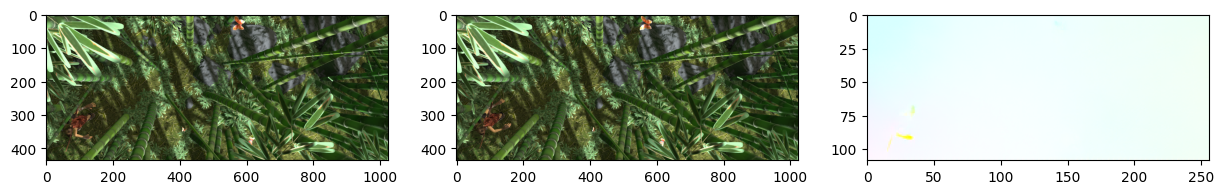

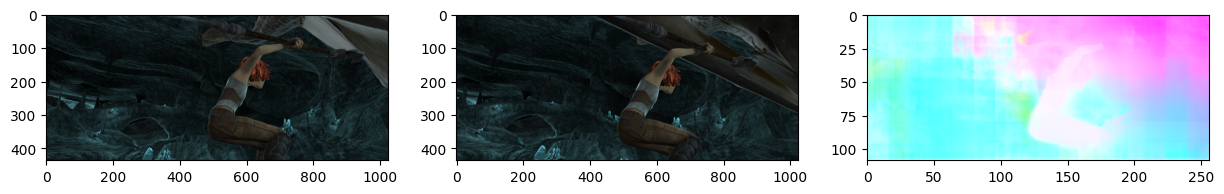

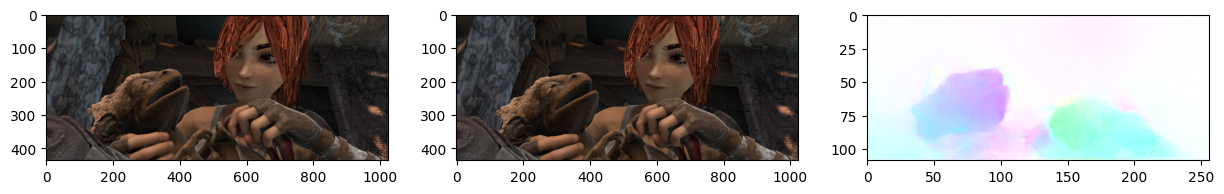

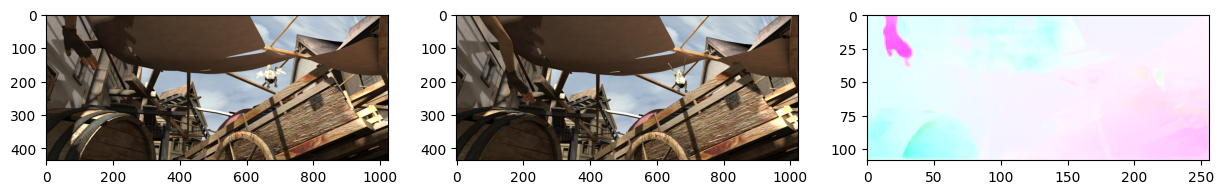

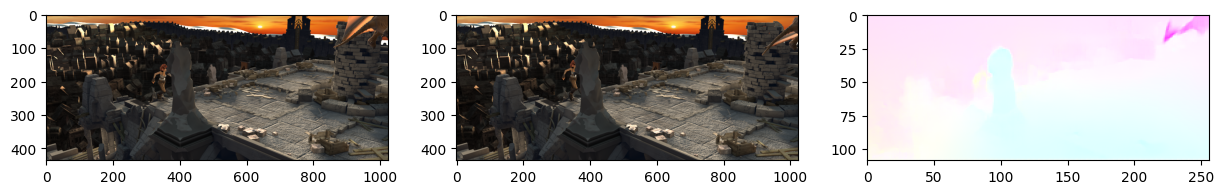

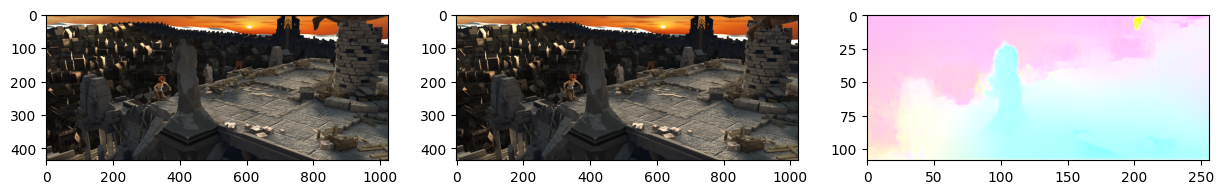

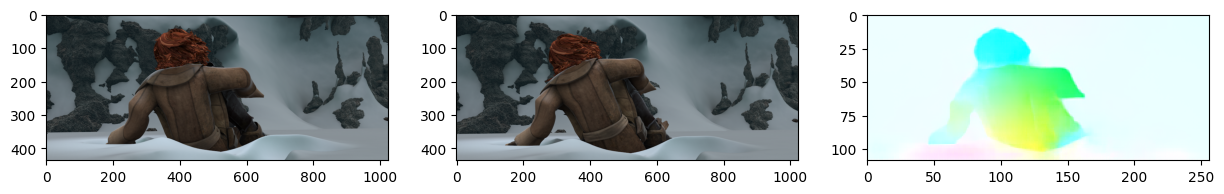

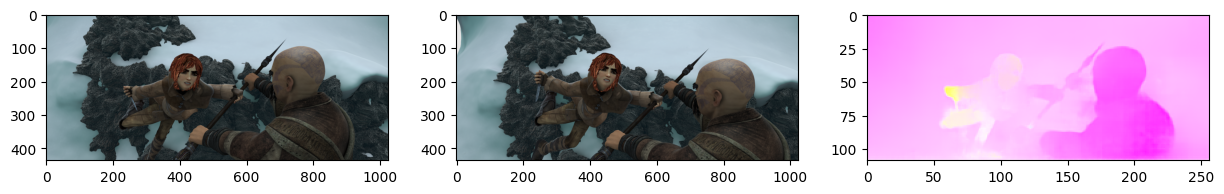

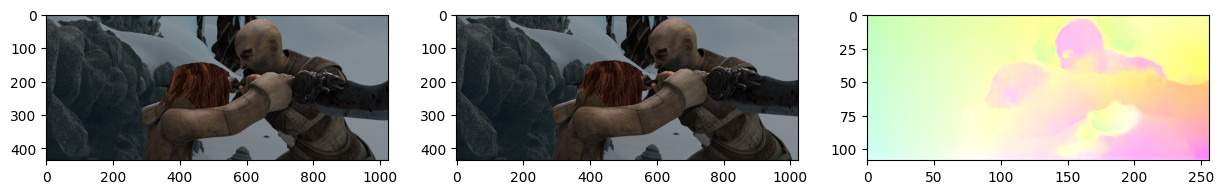

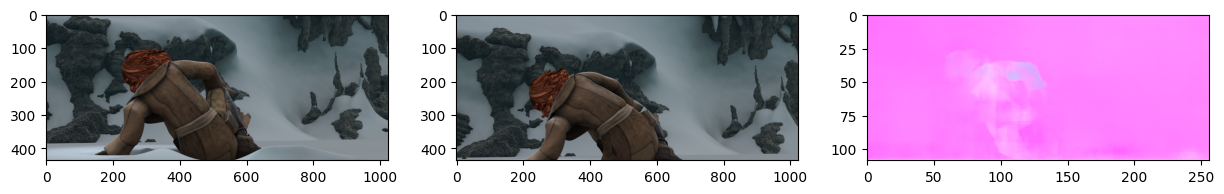

In [6]:
ops = inference(model, imgs_batch, 'mps')

for i in range(n):
  plt.figure(figsize=(15, 10))
  plt.subplot(1, 3, 1)
  plt.imshow(imgs_batch[i][0].permute(1, 2, 0)[..., :3].numpy())
  plt.subplot(1, 3, 2)
  plt.imshow(imgs_batch[i][0].permute(1, 2, 0)[..., 3:].numpy())
  plt.subplot(1, 3, 3)
  plt.imshow(flow2rgb(ops[i][0], None).transpose(1, 2, 0))
  plt.show()

## Finetuning

### Data Preparation

In [7]:
from torch.utils.data import Dataset

input_transform = transforms.Compose(
        [
            # transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]),
            # transforms.Normalize(mean=[0.411, 0.432, 0.45], std=[1, 1, 1]),
        ]
    )

class OpticalFlowDataset(Dataset):
  def __init__(self, img1_batch, img2_batch, flows, folder):
    assert len(img1_batch) == len(img2_batch) == len(flows), "Sizes should match"
    self.first_images = img1_batch
    self.second_images = img2_batch
    self.flows = flows
    self.folder = folder

  def __getitem__(self, idx):
    im1 = self.first_images[idx] / 255
    im2 = self.second_images[idx] / 255
    im1, im2 = input_transform(im1), input_transform(im2)
    inputs = torch.cat([im1, im2])
    return (inputs, self.flows[idx])

  def __len__(self):
    return len(self.first_images)

  def __repr__(self):
    return f"""{self.__class__.__name__}(folder='{self.folder}', length={len(self)})"""

### Dataset Preparation

Split and prepare dataset from video files:
```py
import tempfile
from pathlib import Path
from urllib.request import urlretrieve
from torchvision.io import read_video
from torchvision.models.optical_flow import raft_large
from tqdm.auto import tqdm
import random
from skimage.metrics import structural_similarity as ssim

def video_to_frames(video_path):
  if video_path[:9] == 'https://':
    video_path = Path(tempfile.mkdtemp()) / "temp.mp4"
    _ = urlretrieve(video_url, video_path)

  frames, _, _ = read_video(str(video_path), pts_unit='sec')
  frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

  return frames

device = 'mps'

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

def get_flows(img1_batch, img2_batch, device):
  flows = []
  for i in tqdm(range(len(img1_batch))):
    flow = model(img1_batch[i].unsqueeze(0).to(device), img2_batch[i].unsqueeze(0).to(device))
    flow = flow[-1].detach().cpu()[0]
    flows.append(flow)
  return flows

def prepare_dataset(videos_folder, offset=50, step=10, sample=-1):
  img1_batch = []
  img2_batch = []
  scores = []

  sample = sample if sample != -1 else len(os.listdir(videos_folder))
  vids = random.sample(os.listdir(videos_folder), sample)

  for vid in tqdm(vids, leave=False):
    frames = video_to_frames(videos_folder + vid)
    for i in range(0, len(frames) - offset, step):
        frame1 = frames[i]
        frame2 = frames[i + offset]
        ssim_score = ssim(frame1.numpy(), frame2.numpy(), multichannel=True, channel_axis=0)
        scores.append(ssim_score)

        img1_batch.append(frame1)
        img2_batch.append(frame2)
    
    # img1_batch.extend([frames[i] for i in range(0, len(frames) - offset, step)])
    # img2_batch.extend([frames[i+offset] for i in range(0, len(frames) - offset, step)])
  
  # Top 25% of the frames
  threshold = np.percentile(scores, 75)
  img1_batch = [img1_batch[i] for i in range(len(img1_batch)) if scores[i] > threshold]
  img2_batch = [img2_batch[i] for i in range(len(img2_batch)) if scores[i] > threshold]

    
  # img1_batch, img2_batch = torch.stack(img1_batch), torch.stack(img2_batch)
  img1_batch, img2_batch = torch.stack(img1_batch + img2_batch), torch.stack(img2_batch + img1_batch)

  preprocess = transforms.Compose(
        [
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            transforms.Resize(size=(520, 960)),
        ]
    )

  flows = get_flows(preprocess(img1_batch), preprocess(img2_batch), device)
  flows = torch.stack(flows, dim=0)

  return OpticalFlowDataset(img1_batch, img2_batch, flows, videos_folder)

train_folder = "videos/train/"
test_folder = "videos/test/"

train_ds = prepare_dataset(train_folder, offset=10, step=10)
test_ds = prepare_dataset(test_folder, offset=10, step=10)

torch.save(train_ds, 'train_ds.pt')
torch.save(test_ds, 'test_ds.pt')
```

In [8]:
train_ds = torch.load('train_ds.pt', weights_only=False)
test_ds = torch.load('test_ds.pt', weights_only=False)

In [9]:
len(train_ds), len(test_ds)

(578, 72)

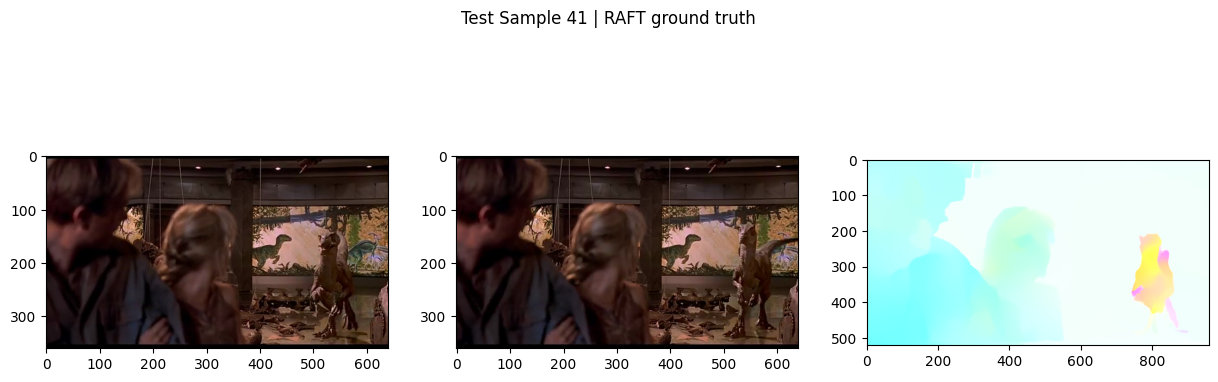

In [10]:
import random

idx = random.sample(range(len(test_ds)), 1)[0]

plt.figure(figsize=(15, 5))
plt.suptitle(f"Test Sample {idx} | RAFT ground truth")

plt.subplot(1, 3, 1)
plt.imshow(test_ds[idx][0].permute(1, 2, 0)[..., :3])
plt.subplot(1, 3, 2)
plt.imshow(test_ds[idx][0].permute(1, 2, 0)[..., 3:])
plt.subplot(1, 3, 3)
plt.imshow(flow2rgb(test_ds[idx][1], None).transpose(1, 2, 0))

Cleaning:
```py
# Clean based on flows

manual_cleaning = []

for idx in range(len(test_ds)):
    size = test_ds[idx][2][1].shape[0] * test_ds[idx][2][1].shape[1]
    if np.abs(test_ds[idx][2][1]).sum() / size > 3:
        manual_cleaning.append(idx)

print(f"Pruning out {len(manual_cleaning) / len(test_ds):.2%} of the test dataset")
test_ds = OpticalFlowDataset(
    img1_batch=torch.stack([test_ds[i][0] for i in range(len(test_ds)) if i not in manual_cleaning]),
    img2_batch=torch.stack([test_ds[i][1] for i in range(len(test_ds)) if i not in manual_cleaning]),
    flows=torch.stack([test_ds[i][2] for i in range(len(test_ds)) if i not in manual_cleaning]),
    folder='test'
    )


manual_cleaning = []

for idx in range(len(train_ds)):
    size = train_ds[idx][2][1].shape[0] * train_ds[idx][2][1].shape[1]
    if np.abs(train_ds[idx][2][1]).sum() / size > 3:
        manual_cleaning.append(idx)

print(f"Pruning out {len(manual_cleaning) / len(train_ds):.2%} of the train dataset")
train_ds = OpticalFlowDataset(
    img1_batch=torch.stack([train_ds[i][0] for i in range(len(train_ds)) if i not in manual_cleaning]),
    img2_batch=torch.stack([train_ds[i][1] for i in range(len(train_ds)) if i not in manual_cleaning]),
    flows=torch.stack([train_ds[i][2] for i in range(len(train_ds)) if i not in manual_cleaning]),
    folder='train'
    )
```

In [11]:
len(test_ds)

72

In [ ]:
ds = test_ds
for idx in range(len(ds)):
  
  inp, gt = ds[idx]
  inp = inp.unsqueeze(0)
  inp = inp.to('mps')
  op = model(inp)


  plt.figure(figsize=(15, 5))
  plt.subplot(1, 4, 1)
  plt.imshow(inp[0].permute(1, 2, 0)[..., :3].cpu().numpy())
  plt.subplot(1, 4, 2)
  plt.imshow(inp[0].permute(1, 2, 0)[..., 3:].cpu().numpy())
  plt.subplot(1, 4, 3)
  plt.imshow(flow2rgb(gt, None).transpose(1, 2, 0))
  plt.subplot(1, 4, 4)
  plt.imshow(flow2rgb(op[0], None).transpose(1, 2, 0))
  plt.suptitle(f"{idx}")
  plt.show()

In [13]:
# Logging Utils
from IPython.display import clear_output, display
import pandas as pd

class MyLogger:
    def __init__(self):
        self.cached_df = None

    def log_metrics(self, dictionary, index_key="epoch"):
        clear_output(wait=True)

        if self.cached_df is not None:
            oncoming = pd.DataFrame.from_records([dictionary])
            if index_key in oncoming.columns:
                oncoming = oncoming.set_index(index_key)
            self.cached_df = pd.concat([self.cached_df, oncoming])
        else:
            self.cached_df = pd.DataFrame.from_records([dictionary])

        if index_key in self.cached_df.columns:
            self.cached_df = self.cached_df.set_index(index_key)
        display(self.cached_df)

    def plot_run(self, keys=None, log=False):
        if keys is None:
            keys = self.cached_df.columns

        for key in keys:
            plt.plot(self.cached_df[key], label=key)

        if log:
            plt.yscale("log")
        plt.legend()
        plt.show()

In [14]:
from FlowNetPytorch.multiscaleloss import realEPE, multiscaleEPE
from FlowNetPytorch.util import AverageMeter

model1 = load_pretrained('flownets_EPE1.951.pth', 'mps')
model1.to('mps')

FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4_1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512,

In [15]:
model1(torch.rand(1, 6, 384, 512).to('mps'))[0].shape

torch.Size([1, 2, 96, 128])

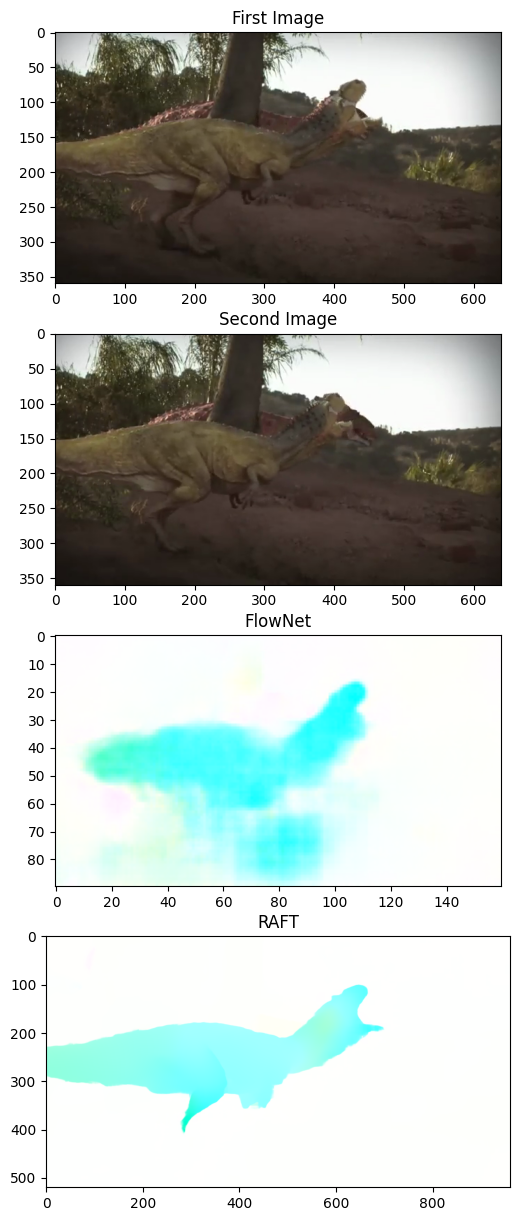

In [17]:
from torchvision.models.optical_flow import raft_large

idx = 86

ops = model1(train_ds[idx][0].unsqueeze(0).to('mps'))
raft = raft_large(pretrained=True, progress=False).to('mps')
raft = raft.eval()

im1, im2 = train_ds[idx][0][:3, ...].unsqueeze(0).to('mps'), train_ds[idx][0][3:, ...].unsqueeze(0).to('mps')

flow = raft(im1, im2)
flow = flow[-1].detach().cpu()[0]

im1, im2 = im1.cpu(), im2.cpu()

plt.figure(figsize=(15, 15))
plt.subplot(4, 1, 1)
plt.title("First Image")
plt.imshow(im1[0].permute(1, 2, 0))
plt.subplot(4, 1, 2)
plt.title("Second Image")
plt.imshow(im2[0].permute(1, 2, 0))
plt.subplot(4, 1, 3)
plt.title("FlowNet")
plt.imshow(flow2rgb(ops[0][0], None).transpose(1, 2, 0))
plt.subplot(4, 1, 4)
plt.title("RAFT")
plt.imshow(flow2rgb(train_ds[idx][1], None).transpose(1, 2, 0))


In [18]:
# Finetuning

for name, param in model1.named_parameters():
    param.requires_grad = True

for name, param in model1.named_parameters():
    if 'deconv' in name:
        param.requires_grad = False

In [19]:
total_params = 0
for name, parameter in model1.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    total_params+=param
print(f"Total Trainable Params: {total_params}")
total_params = 0
for name, parameter in model1.named_parameters():
    param = parameter.numel()
    total_params+=param
print(f"Total Params: {total_params}")


Total Trainable Params: 24112208
Total Params: 38675536


In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=8, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8, pin_memory=True, shuffle=False)

In [22]:
from tqdm.auto import tqdm

input_transform = transforms.Compose(
  [
    # transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]), 
    # transforms.Normalize(mean=[0.411, 0.432, 0.45], std=[1, 1, 1])
  ]
)

def evaluate(model, val_loader, device):
  model.eval()
  model.to(device)
  EPEs = AverageMeter()

  for i, (inp, target) in enumerate(tqdm(val_loader)):
    inp = inp.to(device)
    op = model(inp)
    flow2_EPE = realEPE(op, target.to(device))
    EPEs.update(flow2_EPE.item(), target.size(0))
  
  idx = 86
  op = model(train_ds[idx][0].unsqueeze(0).to(device))

  plt.figure(figsize=(15, 10))
  plt.subplot(1, 4, 1)
  plt.imshow(train_ds[idx][0].permute(1, 2, 0)[..., :3])
  plt.subplot(1, 4, 2)
  plt.imshow(train_ds[idx][0].permute(1, 2, 0)[..., 3:])
  plt.subplot(1, 4, 3)
  plt.imshow(flow2rgb(op[0], None).transpose(1, 2, 0))
  plt.subplot(1, 4, 4)
  plt.imshow(flow2rgb(train_ds[idx][1], None).transpose(1, 2, 0))
  plt.show()

  return EPEs.avg

  0%|          | 0/73 [00:00<?, ?it/s]

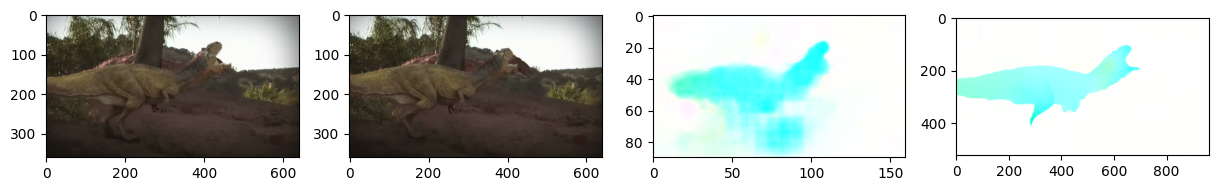

3.800763904017148

In [23]:
evaluate(model1, train_loader, 'mps')

  0%|          | 0/9 [00:00<?, ?it/s]

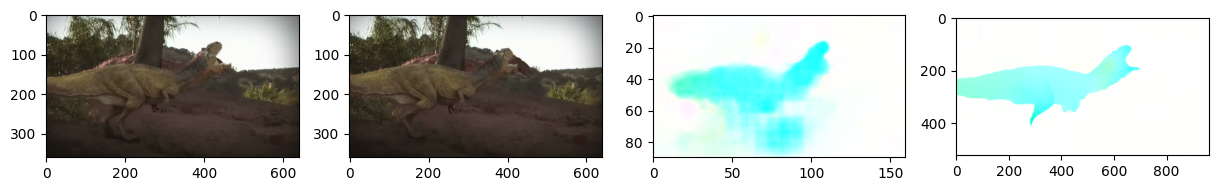

19.617308722601997

In [24]:
evaluate(model1, test_loader, 'mps')

In [25]:
import torch
from tqdm.auto import tqdm

def finetune(model, num_epochs, device, train_loader, test_loader, optimizer, scheduler):
    logger = MyLogger()
    model.train()
    model.to(device)

    for epoch in tqdm(range(num_epochs)):
        logdict = {}

        train_loss, train_EPE = train(train_loader, model, optimizer, epoch, device)

        logdict = {'Epoch': epoch, 'Train Loss': train_loss, 'Train EPE': train_EPE}

        with torch.no_grad():
            val_EPE = evaluate(model, test_loader, device)
            logdict['Val EPE'] = val_EPE
        
        scheduler.step(val_EPE)

        logger.log_metrics(logdict)

    return model

def train(train_loader, model, optimizer, epoch, device):
    losses = AverageMeter()
    flow2_EPEs = AverageMeter()
    model.train()

    for i, (inp, target) in enumerate(tqdm(train_loader, leave=False)):
        target = target.to(device)
        inp = inp.to(device)

        output = model(inp)

        optimizer.zero_grad()

        loss = multiscaleEPE(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        flow2_EPE = realEPE(output[0], target)

        losses.update(loss.item(), target.size(0))
        flow2_EPEs.update(flow2_EPE.item(), target.size(0))

    return losses.avg, flow2_EPEs.avg


# import torch
# from tqdm.auto import tqdm
# import torch.nn.functional as F

# def finetune(model, num_epochs, device, train_loader, test_loader, optimizer, scheduler):
#     logger = MyLogger()
#     model.to(device)
#     best_val_epe = float('inf')

#     for epoch in tqdm(range(num_epochs)):
#         model.train()
#         train_loss, train_epe = train(train_loader, model, optimizer, device)
        
#         # Validate with no gradient computation
#         with torch.no_grad():
#             model.eval()
#             val_epe = evaluate(model, test_loader, device)

#         # Adaptive learning rate scheduling
#         scheduler.step(val_epe)

#         # Logging
#         logdict = {
#             'Epoch': epoch, 
#             'Train Loss': train_loss, 
#             'Train EPE': train_epe,
#             'Val EPE': val_epe
#         }
#         logger.log_metrics(logdict)

#         # Model checkpoint (optional)
#         if val_epe < best_val_epe:
#             best_val_epe = val_epe
#             torch.save(model.state_dict(), 'best_model.pth')

#     return model

# def train(train_loader, model, optimizer, device):
#     losses = AverageMeter()
#     flow_epes = AverageMeter()
    
#     model.train()
    
#     for inp, target in tqdm(train_loader, leave=False):
#         optimizer.zero_grad()
        
#         inp = inp.to(device)
#         target = target.to(device)
        
#         # Forward pass
#         output = model(inp)
        
#         # Compute loss with gradient clipping
#         loss = multiscaleEPE(output, target)
#         loss.backward()
        
#         # Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()
        
#         # Compute EPE
#         flow2_epe = realEPE(output[0], target)
        
#         # Update meters
#         losses.update(loss.item(), inp.size(0))
#         flow_epes.update(flow2_epe.item(), inp.size(0))
    
#     return losses.avg, flow_epes.avg

In [26]:
optimizer = torch.optim.AdamW(model1.parameters(), 1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)

/Users/irsh/Documents/workdir/ec69210/exp5/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [27]:
trained_model = finetune(model1, 20, 'mps', train_loader, test_loader, optimizer, scheduler)

Epoch  Train Loss  Train EPE    Val EPE
0      0  578.303387   3.570414  18.265528
0      1  443.712635   2.754710  16.912114
0      2  379.204750   2.358542  14.690620
0      3  344.536698   2.138085  14.563534
0      4  314.366872   1.957074  14.712557
0      5  280.219458   1.751717  14.208051
0      6  255.052681   1.598994  14.992691
0      7  249.753889   1.566724  14.543508
0      8  235.648548   1.482532  14.481510
0      9  229.133599   1.451038  14.313447
0     10  215.754714   1.372624  14.586221
0     11  205.978617   1.313231  14.093581
0     12  191.741140   1.228739  14.492779
0     13  187.254453   1.198517  13.778864
0     14  176.414670   1.131543  14.051947
0     15  179.840847   1.155947  13.791576
0     16  175.331369   1.130013  13.765640
0     17  164.890173   1.067741  13.956628
0     18  167.835927   1.089256  13.905711
0     19  155.299736   1.010356  14.084459

In [31]:
torch.save(trained_model.state_dict(), 'flownets_dinosaurs.pth')

In [32]:
trained_model = FlowNetS(batchNorm=False)
trained_model.load_state_dict(torch.load('flownets_dinosaurs.pth'))

<All keys matched successfully>

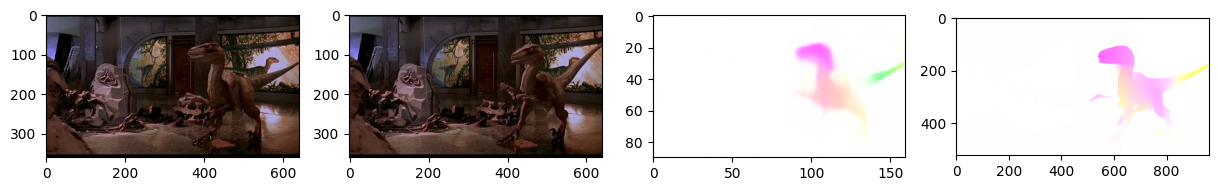

In [62]:
trained_model.to('mps')
trained_model.eval()
input_transform = transforms.Compose(
  [
    # transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]),
    # transforms.Normalize(mean=[0.411, 0.432, 0.45], std=[1, 1, 1]),
  ]
)

imgs_batch = []
ds = test_ds
idx = random.sample(range(len(ds)), 1)[0]
inp = ds[idx][0]
im1, im2 = inp[:3, ...], inp[3:, ...]
target = ds[idx][1]

op = trained_model(inp.unsqueeze(0).to('mps'))

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(im1.permute(1, 2, 0))
plt.subplot(1, 4, 2)
plt.imshow(im2.permute(1, 2, 0))
plt.subplot(1, 4, 3)
plt.imshow(flow2rgb(op[0].cpu(), None).transpose(1, 2, 0))
if target is not None:
  plt.subplot(1, 4, 4)
  plt.imshow(flow2rgb(target, None).transpose(1, 2, 0))
plt.show()

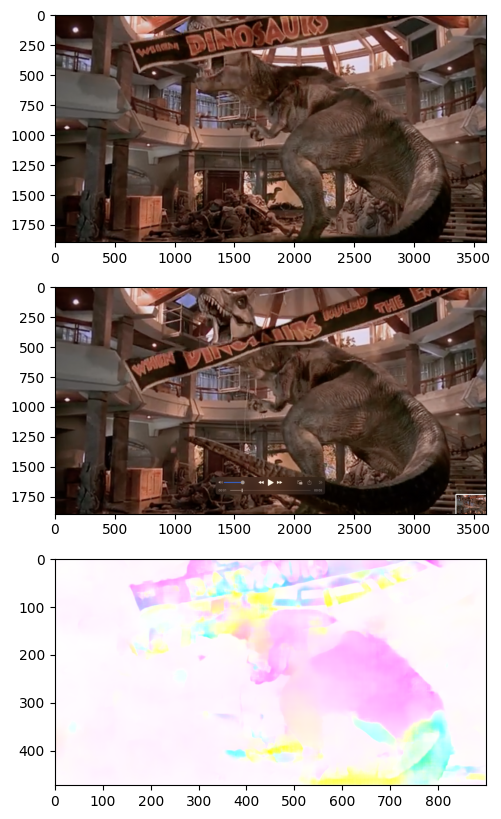

In [48]:
im1 = load_image('test_images/01.png')[..., :3] / 255
im2 = load_image('test_images/02.png')[..., :3] / 255

inp = torch.cat([torch.Tensor(im1).permute(2, 0, 1), torch.Tensor(im2).permute(2, 0, 1)])
inp = input_transform(inp)

op = trained_model(inp.unsqueeze(0).to('mps'))

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.imshow(im1)
plt.subplot(3, 1, 2)
plt.imshow(im2)
plt.subplot(3, 1, 3)
plt.imshow(flow2rgb(op[0].cpu(), None).transpose(1, 2, 0))
plt.show()

In [ ]:
ds = test_ds

for idx in range(len(ds)):
    inp = ds[idx][0]
    im1, im2 = inp[:3, ...], inp[3:, ...]
    target = ds[idx][1]

    op = trained_model(inp.unsqueeze(0).to('mps'))

    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Test Sample {idx}")
    plt.subplot(1, 4, 1)
    plt.title(f"Image 1")
    plt.imshow(im1.permute(1, 2, 0))
    plt.subplot(1, 4, 2)
    plt.title(f"Image 2")
    plt.imshow(im2.permute(1, 2, 0))
    plt.subplot(1, 4, 3)
    plt.title(f"Predicted Flow")
    plt.imshow(flow2rgb(op[0].cpu(), None).transpose(1, 2, 0))
    plt.subplot(1, 4, 4)
    plt.title(f"Ground Truth Flow")
    plt.imshow(flow2rgb(target, None).transpose(1, 2, 0))
    plt.show()